### Introduction

**Goal:**
This project aims to analyze customer bank details and past behavior to predict whether customers are likely to leave soon. 

**Instructions:**
The task involves 
- examining `/datasets/Churn.csv` for class imbalance
- using 2 techniques to address this imbalance
- building a model 
- improving its quality
- Finally, comparing the AUC-ROC metric and F1-score. 

**Measure of Success:**
The model's threshold of success is an F1-score of 0.59.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
data= pd.read_csv('/datasets/Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
data.columns= data.columns.str.lower()
data.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

In [4]:
data.duplicated().sum()

0

In [5]:
data.isnull().sum()

rownumber            0
customerid           0
surname              0
creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64

In [6]:
percentage_of_missing= data.isnull().sum()/len(data)*100
print(percentage_of_missing)

rownumber          0.00
customerid         0.00
surname            0.00
creditscore        0.00
geography          0.00
gender             0.00
age                0.00
tenure             9.09
balance            0.00
numofproducts      0.00
hascrcard          0.00
isactivemember     0.00
estimatedsalary    0.00
exited             0.00
dtype: float64


In [7]:
data.head(15)

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [8]:
data[data['tenure'].isnull()].head(25)

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,83,15641732,Mills,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,100,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,112,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


In [9]:
data['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

### My Thoughts So Far
Upon inspection, I found that missing data accounts for only **9%** of the dataset and appears in the **'tenure'** column only. Since the proportion is relatively small and there does not appear to be any correlation between the missing values and other features, I’ve decided to impute the missing values with zeros and proceed with the analysis. 

In [10]:
data.fillna(0, inplace=True)

In [11]:
data['tenure']= data['tenure'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           10000 non-null  int64  
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [12]:
data['surname'].value_counts()

Smith      32
Scott      29
Martin     29
Walker     28
Brown      26
           ..
Groom       1
Ah Mouy     1
Percy       1
Cover       1
Brodney     1
Name: surname, Length: 2932, dtype: int64

In [13]:
data['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

In [14]:
data['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

In [15]:
data['age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64

In [16]:
data['tenure'].value_counts()

0     1291
1      952
2      950
8      933
3      928
5      927
7      925
4      885
9      882
6      881
10     446
Name: tenure, dtype: int64

In [17]:
data['hascrcard'].value_counts()

1    7055
0    2945
Name: hascrcard, dtype: int64

In [18]:
data['isactivemember'].value_counts()

1    5151
0    4849
Name: isactivemember, dtype: int64

In [19]:
# Performing One-Hot-Encoding on categorical columns
columns_to_encode= ['geography', 'gender']
data_ohe= pd.get_dummies(data, columns=columns_to_encode, drop_first=True)
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rownumber          10000 non-null  int64  
 1   customerid         10000 non-null  int64  
 2   surname            10000 non-null  object 
 3   creditscore        10000 non-null  int64  
 4   age                10000 non-null  int64  
 5   tenure             10000 non-null  int64  
 6   balance            10000 non-null  float64
 7   numofproducts      10000 non-null  int64  
 8   hascrcard          10000 non-null  int64  
 9   isactivemember     10000 non-null  int64  
 10  estimatedsalary    10000 non-null  float64
 11  exited             10000 non-null  int64  
 12  geography_Germany  10000 non-null  uint8  
 13  geography_Spain    10000 non-null  uint8  
 14  gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(9), object(1), uint8(3)
memory usage: 966.9+ KB


In [20]:
to_int=['geography_Germany', 'geography_Spain', 'gender_Male']
data_ohe[to_int]=data_ohe[to_int].astype('int')
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rownumber          10000 non-null  int64  
 1   customerid         10000 non-null  int64  
 2   surname            10000 non-null  object 
 3   creditscore        10000 non-null  int64  
 4   age                10000 non-null  int64  
 5   tenure             10000 non-null  int64  
 6   balance            10000 non-null  float64
 7   numofproducts      10000 non-null  int64  
 8   hascrcard          10000 non-null  int64  
 9   isactivemember     10000 non-null  int64  
 10  estimatedsalary    10000 non-null  float64
 11  exited             10000 non-null  int64  
 12  geography_Germany  10000 non-null  int64  
 13  geography_Spain    10000 non-null  int64  
 14  gender_Male        10000 non-null  int64  
dtypes: float64(2), int64(12), object(1)
memory usage: 1.1+ MB


In [21]:
# Splitting up features and target columns. Also dropping 'surname' column as it's unnecessary for the analysis.
features= data_ohe.drop(['exited', 'surname', 'rownumber', 'customerid'],axis=1)
target= data_ohe['exited']

In [22]:
# Splitting the train/temp sets
features_train, temp_train, target_train, temp_target= train_test_split(features, target, test_size= 0.4, random_state=42)

In [23]:
# Splitting the temp sets into testing and validation sets
features_valid, features_test, target_valid, target_test= train_test_split(temp_train, temp_target, test_size=0.5, random_state=42)

In [24]:
# Scaling the features
numeric= ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard','isactivemember',
          'estimatedsalary', 'geography_Germany', 'geography_Spain', 'gender_Male']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric]= scaler.transform(features_train[numeric])
features_valid[numeric]= scaler.transform(features_valid[numeric])
features_test[numeric]= scaler.transform(features_test[numeric])

/tmp/ipykernel_365/1991493275.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric]= scaler.transform(features_train[numeric])
/.venv/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_365/1991493275.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [25]:
features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
9761,1.603068,2.027653,-1.457665,-0.048229,0.824078,0.645833,0.964303,-1.452982,1.755458,-0.580686,-1.108151
3159,1.883194,-1.520072,-0.168647,0.884122,-0.905967,0.645833,-1.037018,-1.403696,-0.569652,-0.580686,0.902404
1489,-0.451185,0.014079,1.120372,1.050751,-0.905967,-1.548389,0.964303,1.290549,-0.569652,-0.580686,-1.108151
2987,0.243941,-1.232419,-1.135410,0.517839,-0.905967,-1.548389,-1.037018,-0.709924,1.755458,-0.580686,-1.108151
812,-1.416062,-0.561228,-0.490901,-1.214721,0.824078,0.645833,0.964303,-0.736719,-0.569652,1.722101,-1.108151


In [26]:
# Building the Random Forest model
best_model=None
score=0

for depth in range(1,21):
    model = RandomForestClassifier(n_estimators=70, max_depth=depth, random_state=42)
    model.fit(features_train, target_train)
    predicted_valid=model.predict(features_valid)
    f1= f1_score(target_valid, predicted_valid)
    if f1 > score:
        best_model= model
        score= f1
        max_depth= depth
    
print('F1 score:',score)
print('Max Depth:', max_depth)

F1 score: 0.5742251223491027
Max Depth: 17


### Initial Model Explanation
While building the Random Forest model, I tried a number of different hyperparameters to improve its F1-score. I was able to achieve an **F1-score of ~0.57** using a model with 70 estimators and a max depth of 17. This, however, does not meet the threshold for the assignment. My guess is that by addressing the class imbalance, I may be able to see improvements in the F1-score. 

In [27]:
# One way of addressing class imbalance
model= RandomForestClassifier(n_estimators=70, max_depth=17, random_state=42, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid= model.predict(features_valid)
f1= f1_score(target_valid, predicted_valid)
print(f1)

0.5638474295190713


Using this method to correct class imbalance caused a slight dip in performance, but I will continue with my analysis.

In [28]:
target_train.value_counts()

0    4773
1    1227
Name: exited, dtype: int64

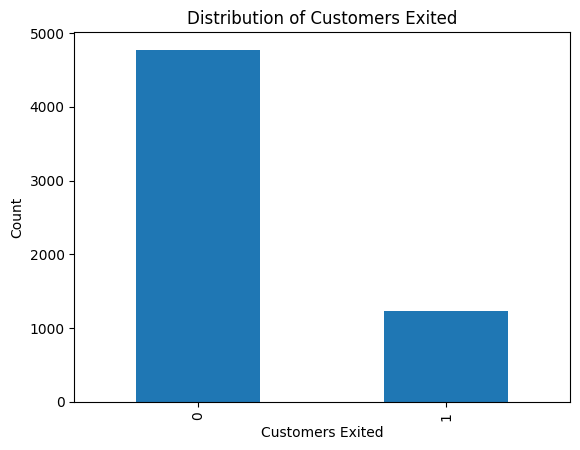

In [29]:
target_train.value_counts().plot(kind='bar')
plt.title('Distribution of Customers Exited')
plt.xlabel('Customers Exited')
plt.ylabel('Count')
plt.show()

In [30]:
# Creating a function to correct class imbalance by upsampling
def upsample(features, target, repeat):
    features_zeroes= features[target==0]
    features_ones= features[target==1]
    target_zeroes= target[target==0]
    target_ones= target[target==1]
    features_upsampled= pd.concat([features_zeroes] + [features_ones] * repeat)
    target_upsampled= pd.concat([target_zeroes] + [target_ones] * repeat )
    features_upsampled,target_upsampled= shuffle(features_upsampled, target_upsampled, random_state=42)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled= upsample(features_train, target_train, 3)

In [31]:
target_upsampled.value_counts()

0    4773
1    3681
Name: exited, dtype: int64

In [32]:
model= RandomForestClassifier(n_estimators=70, max_depth=17, random_state=42)
model.fit(features_upsampled, target_upsampled)
predicted_valid= model.predict(features_valid)
f1= f1_score(target_valid, predicted_valid)
print('F1-Score:',f1)

F1-Score: 0.5794655414908579


### Explanation

To address class imbalance, I experimented with upsampling the positive class by 3 and 4. Upsampling by 4 resulted in the positive class exceeding the size of the negative class, which led to a decline in model performance and a lower F1-score. However, when using 3, the model achieved the F1 score of **~0.58** on the validation set, making it the more effective choice.

In [33]:
# Using the final model on the test set
predicted_test= model.predict(features_test)
f1_score_test= f1_score(target_test, predicted_test)
print('Final Model F1-Score:',f1_score_test)

Final Model F1-Score: 0.6163849154746424


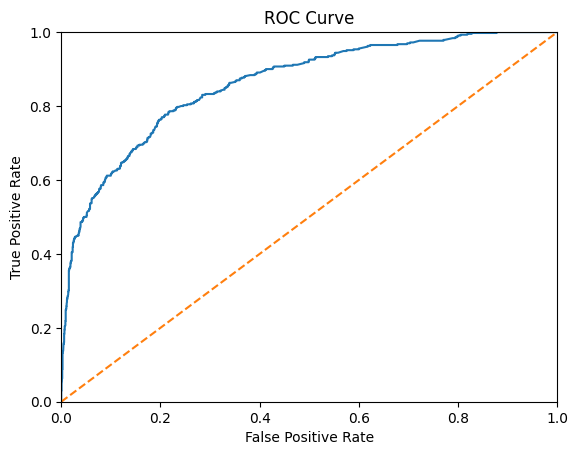

In [34]:
probabilities_test= model.predict_proba(features_test)
probabilities_one_test= probabilities_test[:,1]
fpr,tpr,thresholds= roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0,1] , [0,1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [35]:
auc_roc= roc_auc_score(target_test, probabilities_one_test)
print('AUC ROC Score:', auc_roc)

AUC ROC Score: 0.8605117760331804


### Final Thoughts

Generally the Random Forest model performed well, achieving an AUC-ROC of **0.860**. This indicates a strong ability to distinguish between customers who will churn and those who won’t across various thresholds. Also, the model surpassed the F1-score requirement for this assignment, with a score of **0.6164** on the test set. This suggests that the model performs well in both ranking predictions and classifying churn accurately.